In [1]:
import rdflib
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from graph import *
from rdf2vec import RDF2VecTransformer

In [40]:
print(end='Loading data... ', flush=True)
g = rdflib.Graph()
g.parse('data/new_limit_500k.nt', format="nt")
print('OK')

# Extract all database drugs' URI
all_drugs_file = pd.read_csv('data/all_drugs.tsv', sep='\t')
all_drugs = [rdflib.URIRef(x) for x in all_drugs_file['drug']]

# Define relevant predicates
predicates = pd.read_csv('data/relevant_predicates.tsv', sep='\t')
predicates = [rdflib.URIRef(x) for x in predicates['predicate']]


Loading data... OK


In [41]:
kg = rdflib_to_kg(g, label_predicates=predicates)

In [37]:
#kg = rdflib_to_kg(g, label_predicates=[rdflib.URIRef("http://bio2rdf.org/drugbank_vocabulary:calculated-properties"), rdflib.URIRef("http://purl.org/dc/terms/title")])

#a = extract_instance(kg, "http://bio2rdf.org/drugbank:DB00114")

In [31]:
#print(a)

In [42]:
# Extract graph
#kg = rdflib_to_kg(g, label_predicates=predicates)
i = 1
j = 1
graphs = []
for drug in all_drugs:
    try:
        graphs.append(extract_instance(kg, drug))
        i += 1
    except Exception as e:
        j += 1
        
print('ok:' + str(i))
print('failed:' + str(j))

ok:499
failed:7260


In [97]:
# Embeddings
transformer = RDF2VecTransformer(_type='walk', walks_per_graph=500)
embeddings = transformer.fit_transform(graphs)

kmeans = KMeans(n_clusters=7)
k = kmeans.fit(embeddings)
y_kmeans = kmeans.predict(embeddings)

499it [00:03, 164.67it/s]


In [91]:
# PCA
pca = PCA(n_components=2)
pca = pca.fit_transform(embeddings)

principalDf = pd.DataFrame(data=pca, columns=['pc1', 'pc2'])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)


In [101]:
kmeans2 = KMeans(n_clusters=7)
kmeans2.fit(principalDf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [102]:
print(kmeans2.cluster_centers_)

[[ 0.69425599 -1.16618675]
 [-0.42793744  1.20673438]
 [ 1.46155636  0.15060111]
 [-1.08209315  0.29047893]
 [ 0.01689422 -0.12028459]
 [-0.67291445 -0.77027006]
 [ 1.30147944  1.42027854]]


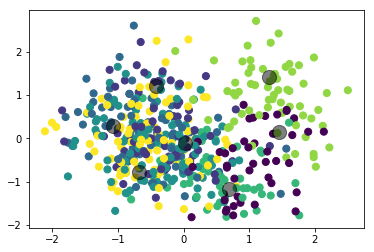

In [104]:
# rappresentazione grafica
plt.scatter(principalDf['pc1'], principalDf['pc2'], c=y_kmeans, s=50, cmap='viridis')

centers = np.asarray(kmeans2.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

In [105]:
# PCA
pca = PCA(n_components=3)
pca = pca.fit_transform(embeddings)

principalDf = pd.DataFrame(data=pca, columns=['pc1', 'pc2', 'pc3'])

kmeans2 = KMeans(n_clusters=7)
kmeans2.fit(principalDf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [108]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

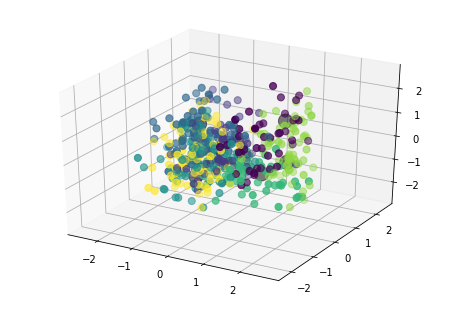

In [110]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(principalDf['pc1'], principalDf['pc2'], principalDf['pc3'], c=y_kmeans, s=50, cmap='viridis')

centers = np.asarray(kmeans2.cluster_centers_)
ax.scatter(centers[:,0], centers[:,1], centers[:,2], c='black', s=200, alpha=0.5)